In [270]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

from Circuit import *

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Encoding a single function

In [271]:
n = 8
qs = np.arange(n)
t = len(qs)
f = np.random.rand(2**n)
f /= np.linalg.norm(f)

def encode_f():
    for q in qs:
        qml.Hadamard(q)
    for x, y in enumerate(f):
        control_values = map(int, format(x, f"0{n}b"))
        theta = np.arccos(y)
        qml.ControlledQubitUnitary(
            [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]],
            control_values=control_values,
            control_wires=qs,
            wires=[t]
        )

circuit = Circuit(n + 1)

print("Encoding f")
circuit.apply(encode_f)

print("Collapsing t to |0>")
circuit.measure(t, 0)

print("Calculating diff == 0: ", end='')
diff = np.linalg.norm(circuit.state[0::2] - f)
print(np.isclose(0, diff))

Encoding f
Collapsing t to |0>
Calculating diff == 0: True


# Pointwise multiplication

In [272]:
ts = len(qs) + np.arange(2)

fs = [
    np.random.rand(2**n),
    np.random.rand(2**n)
]
fs /= np.linalg.norm(fs, axis=1).reshape(2, 1)

def encode_fs():
    for q in qs:
        qml.Hadamard(q)
    for target, function in zip(ts, fs):
        for x, y in enumerate(function):
            control_values = map(int, format(x, f"0{n}b"))
            theta = np.arccos(y)
            qml.ControlledQubitUnitary(
                [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]],
                control_values=control_values,
                control_wires=qs,
                wires=[target]
            )

circuit = Circuit(len(qs) + len(ts))

print("Encoding fs")
circuit.apply(encode_fs)

print("Collapsing ts to |00>")
for t in ts:
    circuit.measure(t, 0)

print("Calculating diff == 0: ", end='')
product = np.prod(fs, axis=0)
product /= np.linalg.norm(product)
diff = np.linalg.norm(product - circuit.state[0::4])
print(np.isclose(0, diff))

Encoding fs
Collapsing ts to |00>
Calculating diff == 0: True


# With Complex Numbers

In [273]:
ts = len(qs) + np.arange(2)

fs = [
    np.random.rand(2**n) + 1j*np.random.rand(2**n),
    np.random.rand(2**n) + 1j*np.random.rand(2**n)
]
fs /= np.linalg.norm(fs, axis=1).reshape(2, 1)

def encode_complex_fs():
    for q in qs:
        qml.Hadamard(q)
    for target, function in zip(ts, fs):
        for x, y in enumerate(function):
            control_values = list(map(int, format(x, f"0{n}b")))
            r = np.arccos(np.absolute(y))
            phi = np.angle(y)
            # encode r
            qml.ControlledQubitUnitary(
                [[np.cos(r), -np.sin(r)], [np.sin(r), np.cos(r)]],
                control_values=control_values,
                control_wires=qs,
                wires=[target]
            )
            # encode phi
            qml.ControlledQubitUnitary(
                [[np.exp(1j * phi), 0], [0, 1]],#np.exp(1j * phi)]],
                control_values=control_values,
                control_wires=qs,
                wires=[target]
            )

circuit = Circuit(len(qs) + len(ts))

print("Encoding fs")
circuit.apply(encode_complex_fs)

print("Collapsing ts to |00>")
for t in ts:
    circuit.measure(t, 0)

print("Calculating diff == 0: ", end='')
product = np.prod(fs, axis=0)
product /= np.linalg.norm(product)
diff = np.linalg.norm(product - circuit.state[0::4])
print(np.isclose(0, diff))

Encoding fs
Collapsing ts to |00>
Calculating diff == 0: True


# Convolution Theorem

In [274]:
fs = np.array([
    np.random.rand(2**(n-1)),
    np.random.rand(2**(n-1))
])

expected = np.pad(np.convolve(*fs), (0, 1), 'constant')
expected /= np.linalg.norm(expected)
padded = np.pad(fs, np.array([(0,0), (0, 2**(n-1))]), 'constant')
ffts = np.fft.fft(padded, axis=1)
product = np.prod(ffts, axis=0)
product /= np.linalg.norm(product)
convolution = np.fft.ifft(product)
convolution /= np.linalg.norm(convolution)

print("iFFT( FFT(f0) x FFT(f1) ) == f0 * f1: ", end='')
print(np.isclose(0, np.linalg.norm(expected - convolution)))

iFFT( FFT(f0) x FFT(f1) ) == f0 * f1: True


# Using a Quantum Circuit

In [275]:
t = len(qs) + len(ts)
ffts /= np.linalg.norm(ffts, axis=1).reshape(2, 1)

def encode_ffts():
    for q in qs:
        qml.Hadamard(q)
    for target, function in zip(ts, ffts):
        for x, y in enumerate(function):
            control_values = list(map(int, format(x, f"0{n}b")))
            r = np.arccos(np.absolute(y))
            phi = np.angle(y)
            # encode r
            qml.ControlledQubitUnitary(
                [[np.cos(r), -np.sin(r)], [np.sin(r), np.cos(r)]],
                control_values=control_values,
                control_wires=qs,
                wires=[target]
            )
            # encode phi
            qml.ControlledQubitUnitary(
                [[np.exp(1j * phi), 0], [0, 1]],
                control_values=control_values,
                control_wires=qs,
                wires=[target]
            )
circuit = Circuit(len(qs) + len(ts))

print("Encoding ffts")
circuit.apply(encode_ffts)

print("Collapsing ts to |00>")
for t in ts:
    circuit.measure(t, 0)

print("Calculating product diff == 0: ", end='')
product = np.prod(ffts, axis=0)
product /= np.linalg.norm(product)
diff = np.linalg.norm(product - circuit.state[0::4])
print(np.isclose(0, diff))

print("Applying QFT")
circuit.apply(qml.QFT, wires=qs)

print("Calculating convolution diff == 0: ", end='')
convolution /= np.linalg.norm(convolution)
diff = np.linalg.norm(convolution - circuit.state[0::4])
print(np.isclose(0, diff))

Encoding ffts
Collapsing ts to |00>
Calculating product diff == 0: True
Applying QFT
Calculating convolution diff == 0: True


# Notes
We are using $n+1$ qubits to encode the convolve two $N$ sized functions

# FFT of second derivative kernel

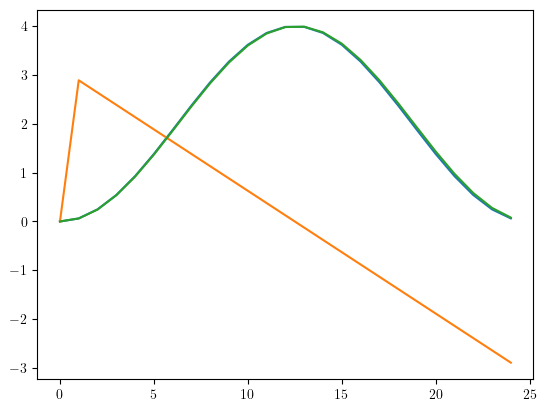

In [340]:
f = [1,-2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# plt.plot(np.real(np.fft.fft(f)))
# plt.plot(np.imag(np.fft.fft(f)))
plt.plot(np.abs(np.fft.fft(f)))
plt.plot(np.angle(np.fft.fft(f)))
plt.plot(range(len(f)), 4*np.sin((np.linspace(0,18,len(f)))/6)**2)

plt.show()